In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mp
import shutil

In [2]:
url = 'C:\\Users\\User\\Downloads\\153.반려동물 안구질환 데이터\\01.데이터\\1.Training\\라벨링데이터\\TL2\\고양이\\안구\\일반\\cat_eye_normal'

In [3]:
unormal_dir = os.path.join(url, 'unormal')
normal_dir= os.path.join(url, 'normal')
train_dir = os.path.join(url, 'train')
test_dir = os.path.join(url, 'test')
val_dir = os.path.join(url, 'val')
# os.mkdir(unormal_dir)
# os.mkdir(train_dir)
# os.mkdir(test_dir)
# os.mkdir(val_dir)

In [4]:
train_unormal_dir = os.path.join(train_dir, 'unormal')
train_normal_dir = os.path.join(train_dir, 'normal')

test_unormal_dir = os.path.join(test_dir, 'unormal')
test_normal_dir = os.path.join(test_dir, 'normal')

val_unormal_dir = os.path.join(val_dir, 'unormal')
val_normal_dir = os.path.join(val_dir, 'normal')

In [30]:
os.mkdir(train_unormal_dir)
os.mkdir(train_normal_dir)

os.mkdir(test_unormal_dir)
os.mkdir(test_normal_dir)

os.mkdir(val_unormal_dir)
os.mkdir(val_normal_dir)

In [5]:
corneal_ulcer_file = os.listdir(url + '/corneal_ulcer')[:500]
corneal_flap_file = os.listdir(url + '/corneal_flap')[:500]
conjunctivitis_file = os.listdir(url + '/conjunctivitis')[:500]
keratitis_file = os.listdir(url + '/keratitis')[:500]
blepharitis_file = os.listdir(url + '/blepharitis')[:500]


In [32]:
for f in corneal_ulcer_file:
    shutil.copy(url + '/corneal_ulcer/' + f, unormal_dir)
for f in corneal_flap_file:
    shutil.copy(url + '/corneal_flap/' + f, unormal_dir)
for f in conjunctivitis_file:
    shutil.copy(url + '/conjunctivitis/' + f, unormal_dir)
for f in keratitis_file:
    shutil.copy(url + '/keratitis/' + f, unormal_dir)
for f in blepharitis_file:
    shutil.copy(url + '/blepharitis/' + f, unormal_dir)

In [6]:
normal_file = os.listdir(url + '/normal')[:2500]
unormal_file = os.listdir(url + '/unormal')[:2500]

In [7]:
len(unormal_file)

2500

In [8]:
print(len(normal_file),len(unormal_file))

2500 2500


In [36]:
for f in normal_file[:2000]:
    shutil.copy(url + '/normal/' + f, train_normal_dir)
for f in unormal_file[:2000]:
    shutil.copy(url + '/unormal/' + f, train_unormal_dir)

for f in normal_file[2000:2250]:
    shutil.copy(url + '/normal/' + f, test_normal_dir)
for f in unormal_file[2000:2250]:
    shutil.copy(url + '/unormal/' + f, test_unormal_dir)

for f in normal_file[2250:]:
    shutil.copy(url + '/normal/' + f, val_normal_dir)
for f in unormal_file[2250:]:
    shutil.copy(url + '/unormal/' + f, val_unormal_dir)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential,Model

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
url+'/train'

'C:\\Users\\User\\Downloads\\153.반려동물 안구질환 데이터\\01.데이터\\1.Training\\라벨링데이터\\TL2\\고양이\\안구\\일반\\cat_eye_normal/train'

In [12]:
train_data_importer = train_datagen.flow_from_directory(
    url+'/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_data_importer = train_datagen.flow_from_directory(
    url+'/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_data_importer = train_datagen.flow_from_directory(
    url+'/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 4000 images belonging to 2 classes.


Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [13]:
#Resnet 레이어 직접 작성
import tensorflow as tf
from tensorflow.keras import layers, models

def identity_block(input_tensor, filters, kernel_size):
    filters1, filters2, filters3 = filters

    x = layers.Conv2D(filters1, (1, 1), kernel_initializer='he_normal')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

def conv_block(input_tensor, filters, kernel_size, strides=(2, 2)):
    filters1, filters2, filters3 = filters

    x = layers.Conv2D(filters1, (1, 1), strides=strides, kernel_initializer='he_normal')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)

    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides, kernel_initializer='he_normal')(input_tensor)
    shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def resnet50():
    input = layers.Input(shape=(224, 224, 3))
    x = layers.ZeroPadding2D((3, 3))(input)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = conv_block(x, [64, 64, 256], (3, 3), strides=(1, 1))
    x = identity_block(x, [64, 64, 256], (3, 3))
    x = identity_block(x, [64, 64, 256], (3, 3))

    x = conv_block(x, [128, 128, 512], (3, 3))
    x = identity_block(x, [128, 128, 512], (3, 3))
    x = identity_block(x, [128, 128, 512], (3, 3))
    x = identity_block(x, [128, 128, 512], (3, 3))

    x = conv_block(x, [256, 256, 1024], (3, 3))
    x = identity_block(x, [256, 256, 1024], (3, 3))
    x = identity_block(x, [256, 256, 1024], (3, 3))
    x = identity_block(x, [256, 256, 1024], (3, 3))
    x = identity_block(x, [256, 256, 1024], (3, 3))
    x = identity_block(x, [256, 256, 1024], (3, 3))

    x = conv_block(x, [512, 512, 2048], (3, 3))
    x = identity_block(x, [512, 512, 2048], (3, 3))
    x = identity_block(x, [512, 512, 2048], (3, 3))

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(2, activation='sigmoid')(x)

    model = models.Model(inputs=input, outputs=x)
    return model

model = resnet50()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     16,640 │ activation_2[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     16,640 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ batch_normalizat

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 23,538,690 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
hist = model.fit(
    train_data_importer,
    epochs=25,
    validation_data=val_data_importer
)

In [ ]:
#Resnet 모델 임포트
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(4, activation='softmax') 
])


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
hist = model.fit(
    train_data_importer,
    epochs=25,
    validation_data=val_data_importer
)

Epoch 1/25


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 690s 5s/step - accuracy: 0.6245 - loss: 1.1185 - val_accuracy: 0.5080 - val_loss: 0.9224
Epoch 2/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 665s 5s/step - accuracy: 0.7856 - loss: 0.4982 - val_accuracy: 0.5460 - val_loss: 0.8177
Epoch 3/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 661s 5s/step - accuracy: 0.8189 - loss: 0.4304 - val_accuracy: 0.7700 - val_loss: 0.5044
Epoch 4/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 662s 5s/step - accuracy: 0.8172 - loss: 0.4094 - val_accuracy: 0.6760 - val_loss: 6.6057
Epoch 5/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 662s 5s/step - accuracy: 0.8399 - loss: 0.3833 - val_accuracy: 0.5380 - val_loss: 4.0283
Epoch 6/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 661s 5s/step - accuracy: 0.8374 - loss: 0.3852 - val_accuracy: 0.7840 - val_loss: 0.7665
Epoch 7/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 662s 5s/step - accuracy: 0.8620 - loss: 0.3457 - val_accuracy: 0.7660 - val_loss: 1.4003
Epoch 8/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 662s 5s/step - accuracy: 0.8668 - loss: 0.3057 - val_accuracy: 0.824

KeyboardInterrupt: 

In [22]:
model.save('resnet50_model.keras')

from tensorflow.keras.models import load_model
model = load_model('resnet50_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


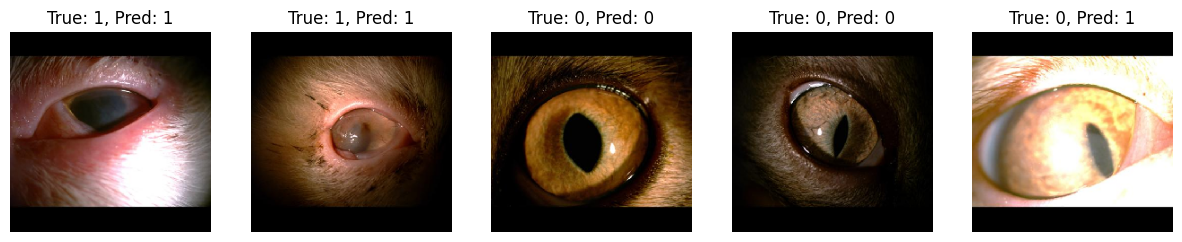

In [31]:
def plot_predictions(model, data_iterator, num_images=5):
    plt.figure(figsize=(15, 15))
    images, labels = data_iterator[0]
    predictions = model.predict(images)
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        image = (images[i] * 255).astype("uint8")
        plt.imshow(image)
        plt.title(f"True: {np.argmax(labels[i])}, Pred: {np.argmax(predictions[i])}")
        plt.axis("off")

plot_predictions(model, test_data_importer)
